In [1]:
local_data_dir = '/Users/shanydanieli/projects/merian/observing/data/'

In [31]:
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
from matplotlib import patches

from astropy import coordinates
from astropy import units as u
from astropy.io import fits

from shapely import geometry
from shapely.ops import unary_union
from shapely.geometry import Point
from descartes.patch import PolygonPatch

from skipper import observe, shape, hsc, tiling


In [3]:
def read_tile_file(filename):
    hdul = fits.open(filename)
    data = hdul[1].data
    tileID = data['TILEID']
    pass_num = data['PASS']
    ra = data['RA']
    dec = data['DEC']
    
    return tileID, pass_num, ra, dec

In [4]:
import datetime

### import tiliing file

In [5]:
tileID, pass_num, ra, dec = read_tile_file('../data/decam-tiles-decals-merian.fits')
tileID_shift, pass_num_shift, ra_shift, dec_shift = read_tile_file('../data/shifted-tiles-decals-merian.fits.gz')
# tileID_shift, pass_num_shift, ra_shift, dec_shift = read_tile_file('../data/shifted-tiles-decals-merian_0.5.fits.gz')

circle_radius = (3.18/np.pi)**0.5

## randoms filtered through the S18A 

In [6]:
# read the healpy map of the S18A data release
mask = hp.read_map(local_data_dir+'s18a_fdfc_hp_contarea.fits', nest=True, dtype = np.bool)
indices_map = np.where(mask)[0]
nside = hp.get_nside(mask)

# read the random catalog in the i-band only
hdul = fits.open(local_data_dir+'/merian_random_iband_only_1.fits')
randoms_data = hdul[1].data

filtered_catalog = hsc.filter_healpix_mask(mask,randoms_data)
ra_s18a = filtered_catalog['ra']
dec_s18a = filtered_catalog['dec']

HSC_S20_fdfc = hp.read_map('../data/s20a_fdfc_hp_contarea_izy-gt-5.fits', nest=True, dtype=np.bool)
filtered_catalog = hsc.filter_healpix_mask(HSC_S20_fdfc,randoms_data)
ra_s20a = filtered_catalog['ra']
dec_s20a = filtered_catalog['dec']

/Users/shanydanieli/anaconda2/envs/astroconda/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/shanydanieli/anaconda2/envs/astroconda/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/shanydanieli/anaconda2/envs/astroconda/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


# 11127341/42406457 objects are selected by the mask
# 19827548/42406457 objects are selected by the mask


### import the GAMA09 field edges in S18A and S20A

In [7]:
gama09_edges_S18A = np.loadtxt('../data/gama09_edges_S18A.dat')
gama12_edges_S18A = np.loadtxt('../data/gama12_edges_S18A.dat')
gama15_edges_S18A = np.loadtxt('../data/gama15_edges_S18A.dat')

gama_edges_S20A = np.loadtxt('../data/gama_edges_S20A.dat')

poly_g09_S18A = geometry.Polygon(gama09_edges_S18A)  
poly_g12_S18A = geometry.Polygon(gama12_edges_S18A)  
poly_g15_S18A = geometry.Polygon(gama15_edges_S18A)  

poly_gama_S20A = geometry.Polygon(gama_edges_S20A)  
# print('The GAMA09 field area in S18A is: ' + str(poly_g09_S18A.area))
# print('The GAMA09 field area in S20A is: ' + str(poly_g09_S20A.area))

In [8]:
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] = 20
plt.rcParams['axes.titlepad'] = 20

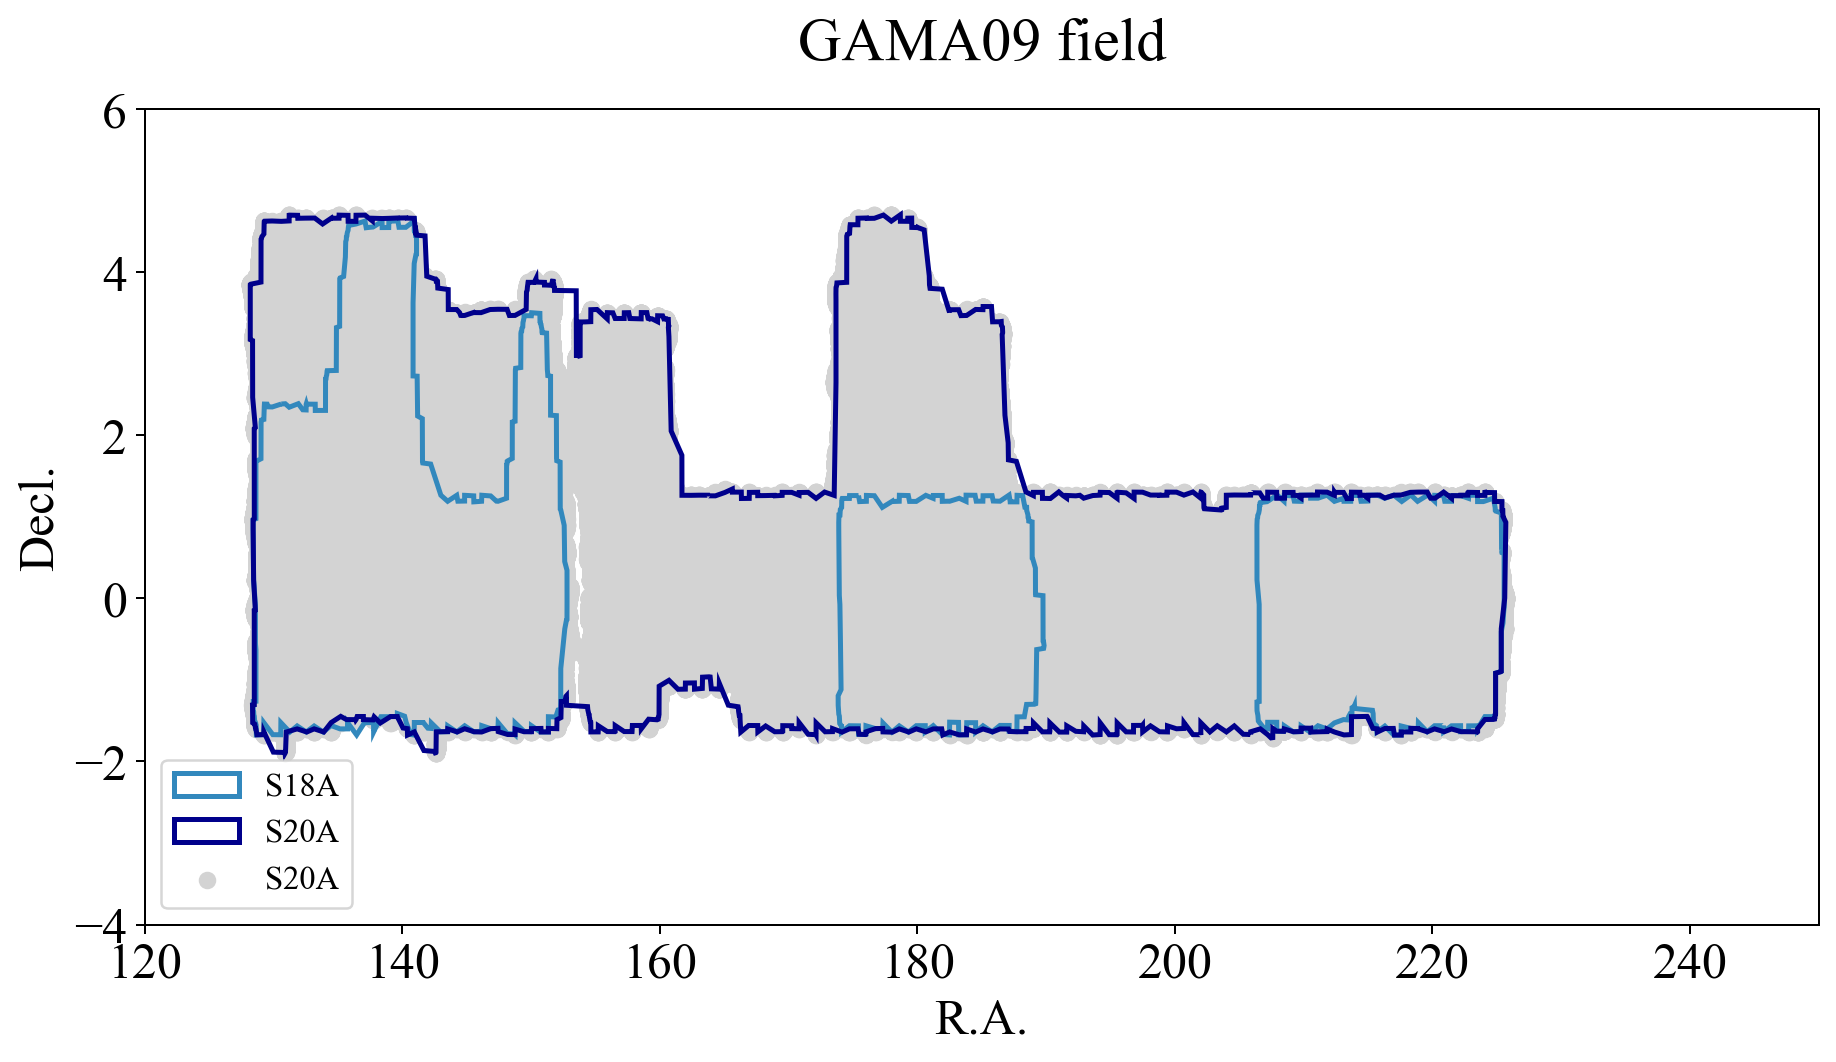

In [9]:
patchS18A_09 = PolygonPatch(poly_g09_S18A, edgecolor='#3288bd',facecolor='none',lw=2, label=r'S18A')
patchS18A_12 = PolygonPatch(poly_g12_S18A, edgecolor='#3288bd',facecolor='none',lw=2)
patchS18A_15 = PolygonPatch(poly_g15_S18A, edgecolor='#3288bd',facecolor='none',lw=2)
patchS20A = PolygonPatch(poly_gama_S20A, edgecolor='darkblue',facecolor='none',lw=2, label=r'S20A')

fig = plt.figure(1, figsize=(12, 6), dpi=180)
ax = fig.add_subplot(111)
ax.add_patch(patchS18A_09)
ax.add_patch(patchS18A_12)
ax.add_patch(patchS18A_15)
ax.add_patch(patchS20A)
ax.scatter(ra_s20a,dec_s20a,color='lightgray', label='S20A')
ax.set_xlim(120,250)
ax.set_ylim(-4,6)
ax.set_title('GAMA09 field')
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
plt.legend(loc='lower left', fontsize=13)



### check the overlap between circles and the HSC footprint


In [10]:
# ra1 = [ra[i] for i in range(len(ra)) if pass_num[i] == 1]
# dec1 = [dec[i] for i in range(len(dec)) if pass_num[i] == 1]
# ra2 = [ra[i] for i in range(len(ra)) if pass_num[i] == 2]
# dec2 = [dec[i] for i in range(len(dec)) if pass_num[i] == 2]
# ra3 = [ra[i] for i in range(len(ra)) if pass_num[i] == 3]
# dec3 = [dec[i] for i in range(len(dec)) if pass_num[i] == 3]
# ra4 = [ra[i] for i in range(len(ra)) if pass_num[i] == 4]
# dec4 = [dec[i] for i in range(len(dec)) if pass_num[i] == 4]

ra1_shift = [ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 1]
dec1_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 1]
ra2_shift = [ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 2]
dec2_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 2]
ra3_shift = [ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 3]
dec3_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 3]
ra4_shift = [ra_shift[i] for i in range(len(ra_shift)) if pass_num_shift[i] == 4]
dec4_shift = [dec_shift[i] for i in range(len(dec_shift)) if pass_num_shift[i] == 4]

## make circles for the original tiling pattern

In [11]:
# # pass 1
# circles_pass1 = [Point(ra1[i],dec1[i]).buffer(circle_radius) for i in range(len(ra1))]
# # all_circles_pass1 = unary_union(circles_pass1)
# # pass 2
# circles_pass2 = [Point(ra2[i],dec2[i]).buffer(circle_radius) for i in range(len(ra2))]
# # all_circles_pass2 = unary_union(circles_pass2)
# # pass 3
# circles_pass3 = [Point(ra3[i],dec3[i]).buffer(circle_radius) for i in range(len(ra3))]
# # all_circles_pass3 = unary_union(circles_pass3)
# # pass 4
# circles_pass4 = [Point(ra4[i],dec4[i]).buffer(circle_radius) for i in range(len(ra4))]
# # all_circles_pass4 = unary_union(circles_pass4)

## make circles for the shifted tiling pattern (shifted by 1 deg in dec)

In [11]:
# pass 1
circles_pass1_shift = [Point(ra1_shift[i],dec1_shift[i]).buffer(circle_radius) for i in range(len(ra1_shift))]
# all_circles_pass1 = unary_union(circles_pass1)
# pass 2
circles_pass2_shift = [Point(ra2_shift[i],dec2_shift[i]).buffer(circle_radius) for i in range(len(ra2_shift))]
# all_circles_pass2 = unary_union(circles_pass2)
# pass 3
circles_pass3_shift = [Point(ra3_shift[i],dec3_shift[i]).buffer(circle_radius) for i in range(len(ra3_shift))]
# all_circles_pass3 = unary_union(circles_pass3)
# pass 4
circles_pass4_shift = [Point(ra4_shift[i],dec4_shift[i]).buffer(circle_radius) for i in range(len(ra4_shift))]
# all_circles_pass4 = unary_union(circles_pass4)

### now we calculate the overlap of pass1 with the HSC GAMA09 area


## non-shifted

In [13]:
# fraction = 0.9

In [14]:
# # pass 1
# pass1_circle_any_overlap = []
# pass1_circle_overlap_index = []
# fov_area = 3.18
# index_use = []
# for i in range(len(circles_pass1)):
#     inter = poly_g09_S20A.intersection(circles_pass1[i])
#     if inter.area > 0:
#         pass1_circle_any_overlap.append(circles_pass1[i])
#         if inter.area/3.18 > fraction:
#             pass1_circle_overlap_index.append(1)
#             index_use.append(i)
#         else:
#             pass1_circle_overlap_index.append(0)
            

# # pass 2
# pass2_circle_any_overlap = []
# pass2_circle_overlap_index = []
# fov_area = 3.18
# for i in range(len(circles_pass2)):
#     inter = poly_g09_S20A.intersection(circles_pass2[i])
#     if inter.area > 0:
#         pass2_circle_any_overlap.append(circles_pass2[i])
#         if inter.area/3.18 > fraction:
#             pass2_circle_overlap_index.append(1)
#         else:
#             pass2_circle_overlap_index.append(0)
            
# # pass 3
# pass3_circle_any_overlap = []
# pass3_circle_overlap_index = []
# fov_area = 3.18
# for i in range(len(circles_pass3)):
#     inter = poly_g09_S20A.intersection(circles_pass3[i])
#     if inter.area > 0:
#         pass3_circle_any_overlap.append(circles_pass3[i])
#         if inter.area/3.18 > fraction:
#             pass3_circle_overlap_index.append(1)
#         else:
#             pass3_circle_overlap_index.append(0)     

# # pass 4
# pass4_circle_any_overlap = []
# pass4_circle_overlap_index = []
# fov_area = 3.18
# for i in range(len(circles_pass4)):
#     inter = poly_g09_S20A.intersection(circles_pass4[i])
#     if inter.area > 0:
#         pass4_circle_any_overlap.append(circles_pass4[i])
#         if inter.area/3.18 > fraction:
#             pass4_circle_overlap_index.append(1)
#         else:
#             pass4_circle_overlap_index.append(0)            

In [15]:
# count = 0
# for i in range(len(pass1_circle_any_overlap)):
#     if pass1_circle_overlap_index[i] == 1:
#         count +=1
# count

## plot non-shifted pointing overlap with S20A and S18A

In [16]:
# patchS18A = PolygonPatch(poly_g09_S18A, edgecolor='darkblue',facecolor='none',lw=2, label=r'S18A, 102 deg$^2$')
# patchS20A = PolygonPatch(poly_g09_S20A, edgecolor='#3288bd',facecolor='none',lw=2, label=r'S20A, 141 deg$^2$')
# fig = plt.figure(1, figsize=(12, 6), dpi=180)
# ax = fig.add_subplot(111, aspect='equal')
# ax.add_patch(patchS18A)
# ax.add_patch(patchS20A)
# ax.scatter(ra_s20a,dec_s20a,color='lightgray', label='S20A')
# count = 0
# for i in range(len(pass1_circle_any_overlap)):
#     if pass1_circle_overlap_index[i] == 1:
#         patch2 = PolygonPatch(pass1_circle_any_overlap[i],lw=1,facecolor='none',edgecolor='#238b45')
#         count +=1
#     else:
#         patch2 = PolygonPatch(pass1_circle_any_overlap[i],lw=1,facecolor='none',edgecolor='#cb181d')
#     ax.add_patch(patch2)
# ax.set_xlim(120,155)
# ax.set_ylim(-4,6.5)
# ax.set_title('GAMA09 (original pattern), minimal required overlap with the G09 field: '+str(round(100*fraction))+'%', fontsize=20, pad=10)
# ax.set_xlabel('R.A.')
# ax.set_ylabel('Decl.')
# plt.legend(loc='lower left', fontsize=12)
# plt.tight_layout()
# plt.savefig('../figures/gama09pointings_org_90.jpeg', bbox_inches='tight', dpi=500)


## shifted

In [70]:
fraction = 0.85
# pass 1
pass1_circle_any_overlap = []
pass1_circle_overlap_index = []
fov_area = 3.18
index_use = []

extra_pointing_poly = geometry.box(129,3.2,139,5)

for i in range(len(circles_pass1_shift)):
    # intersection with the S20A covered area
    inter = poly_gama_S20A.intersection(circles_pass1_shift[i])
    inter2 = extra_pointing_poly.intersection(circles_pass1_shift[i])    
    if inter.area > 0:
        pass1_circle_any_overlap.append(circles_pass1_shift[i])
        if inter.area/3.18 > fraction:
            pass1_circle_overlap_index.append(1)
            index_use.append(i)
        elif inter2.area > 1:
            pass1_circle_overlap_index.append(1)   
            patch = PolygonPatch(circles_pass1_shift[i],lw=0.7,facecolor='none',edgecolor='#238b45')
            index_use.append(i)
        else:
            pass1_circle_overlap_index.append(0)

# pass 2
pass2_circle_any_overlap = []
pass2_circle_overlap_index = []
fov_area = 3.18
for i in range(len(circles_pass2_shift)):
    inter = poly_gama_S20A.intersection(circles_pass2_shift[i])
    inter2 = extra_pointing_poly.intersection(circles_pass2_shift[i])    
    if inter.area > 0:
        pass2_circle_any_overlap.append(circles_pass2_shift[i])
        if inter.area/3.18 > fraction:
            pass2_circle_overlap_index.append(1)
        elif inter2.area > 1:
            pass2_circle_overlap_index.append(1)   
            patch = PolygonPatch(circles_pass2_shift[i],lw=0.7,facecolor='none',edgecolor='#238b45')
        else:
            pass2_circle_overlap_index.append(0)
            
# pass 3
pass3_circle_any_overlap = []
pass3_circle_overlap_index = []
fov_area = 3.18
for i in range(len(circles_pass3_shift)):
    inter = poly_gama_S20A.intersection(circles_pass3_shift[i])
    inter2 = extra_pointing_poly.intersection(circles_pass3_shift[i])    
    if inter.area > 0:
        pass3_circle_any_overlap.append(circles_pass3_shift[i])
        if inter.area/3.18 > fraction:
            pass3_circle_overlap_index.append(1)
        elif inter2.area > 1:
            pass3_circle_overlap_index.append(1)   
            patch = PolygonPatch(circles_pass3_shift[i],lw=0.7,facecolor='none',edgecolor='#238b45')
        else:
            pass3_circle_overlap_index.append(0)     

# pass 4
pass4_circle_any_overlap = []
pass4_circle_overlap_index = []
fov_area = 3.18
for i in range(len(circles_pass4_shift)):
    inter = poly_gama_S20A.intersection(circles_pass4_shift[i])
    inter2 = extra_pointing_poly.intersection(circles_pass4_shift[i])    
    if inter.area > 0:
        pass4_circle_any_overlap.append(circles_pass4_shift[i])
        if inter.area/3.18 > fraction:
            pass4_circle_overlap_index.append(1)
        elif inter2.area > 1:
            pass4_circle_overlap_index.append(1)   
            patch = PolygonPatch(circles_pass4_shift[i],lw=0.7,facecolor='none',edgecolor='#238b45')
        else:
            pass4_circle_overlap_index.append(0)                        


In [71]:
count = 0
for i in range(len(pass1_circle_any_overlap)):
    if pass1_circle_overlap_index[i] == 1:
        count +=1
count

128

## plot shifted pointing overlap with S20A and S18A

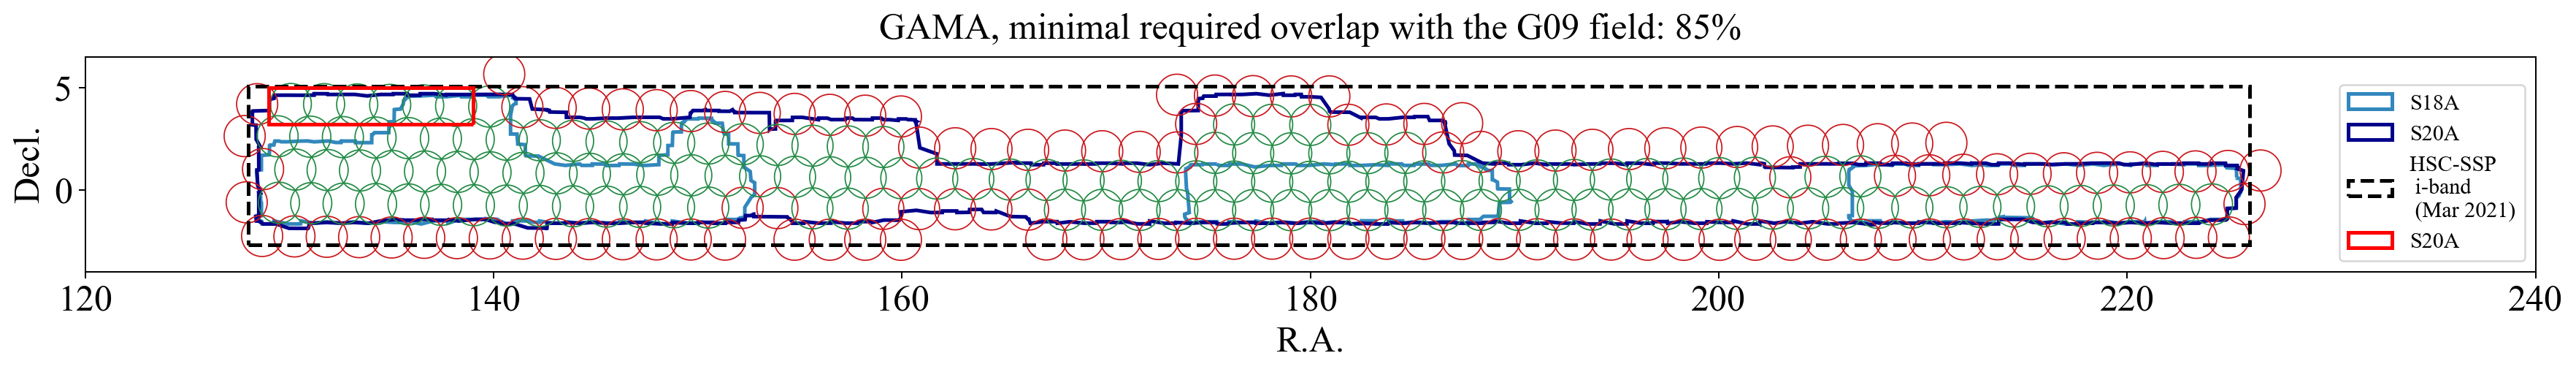

In [72]:
patchS18A_09 = PolygonPatch(poly_g09_S18A, edgecolor='#3288bd',facecolor='none',lw=2, label=r'S18A')
patchS18A_12 = PolygonPatch(poly_g12_S18A, edgecolor='#3288bd',facecolor='none',lw=2)
patchS18A_15 = PolygonPatch(poly_g15_S18A, edgecolor='#3288bd',facecolor='none',lw=2)
patchS20A = PolygonPatch(poly_gama_S20A, edgecolor='darkblue',facecolor='none',lw=2, label=r'S20A')
fig = plt.figure(1, figsize=(20, 10), dpi=180)



ax = fig.add_subplot(111, aspect='equal')
ax.add_patch(patchS18A_09)
ax.add_patch(patchS18A_12)
ax.add_patch(patchS18A_15)
ax.add_patch(patchS20A)
# ax.scatter(ra_s20a,dec_s20a,color='lightgray', label='S20A')
for i in range(len(pass1_circle_any_overlap)):
    if pass1_circle_overlap_index[i] == 1:
        patch2 = PolygonPatch(pass1_circle_any_overlap[i],lw=0.7,facecolor='none',edgecolor='#238b45')
    else:
        patch2 = PolygonPatch(pass1_circle_any_overlap[i],lw=0.7,facecolor='none',edgecolor='#cb181d')
    ax.add_patch(patch2)

# currect (March 2021 survey status)
hscssp_current = patches.Rectangle((128,-2.7),width=98, height=7.77,linewidth=2,edgecolor='k',facecolor='none', ls='--', label='HSC-SSP \n i-band \n (Mar 2021)')
ax.add_patch(hscssp_current)


# add_point = patches.Rectangle((129,3.2),width=10, height=1.8,linewidth=2,edgecolor='r',facecolor='none', ls='--', label='HSC-SSP \n i-band \n (Mar 2021)')
# ax.add_patch(add_point)

extra_pointing_poly = geometry.box(129,3.2,139,5)
patch_test = PolygonPatch(extra_pointing_poly, edgecolor='r',facecolor='none',lw=2, label=r'S20A')
ax.add_patch(patch_test)

    
ax.set_xlim(120,240)
ax.set_ylim(-4,6.5)
ax.set_title('GAMA, minimal required overlap with the G09 field: '+str(round(100*fraction))+'%', fontsize=20, pad=10)
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
# plt.savefig('../figures/gama_pointings_shift_85_n.jpeg', bbox_inches='tight',dpi=500)
# plt.savefig('../figures/gama_pointings_shift_90.jpeg', bbox_inches='tight',dpi=500)


### Calculates the area of all circles that overlap with a fraction larger than the defined minimal fraction

In [73]:
pass1_circle_required_overlap = []
for i in range(len(pass1_circle_any_overlap)):
    if pass1_circle_overlap_index[i] == 1:
        pass1_circle_required_overlap.append(pass1_circle_any_overlap[i])


In [74]:
print(len(pass1_circle_required_overlap))

128


In [75]:
gama_union = unary_union(pass1_circle_required_overlap)

inter = poly_gama_S20A.intersection(gama_union)
diff = gama_union.difference(poly_gama_S20A)
print(inter.area)
print(diff.area)

334.6042474143787
21.241961686794813


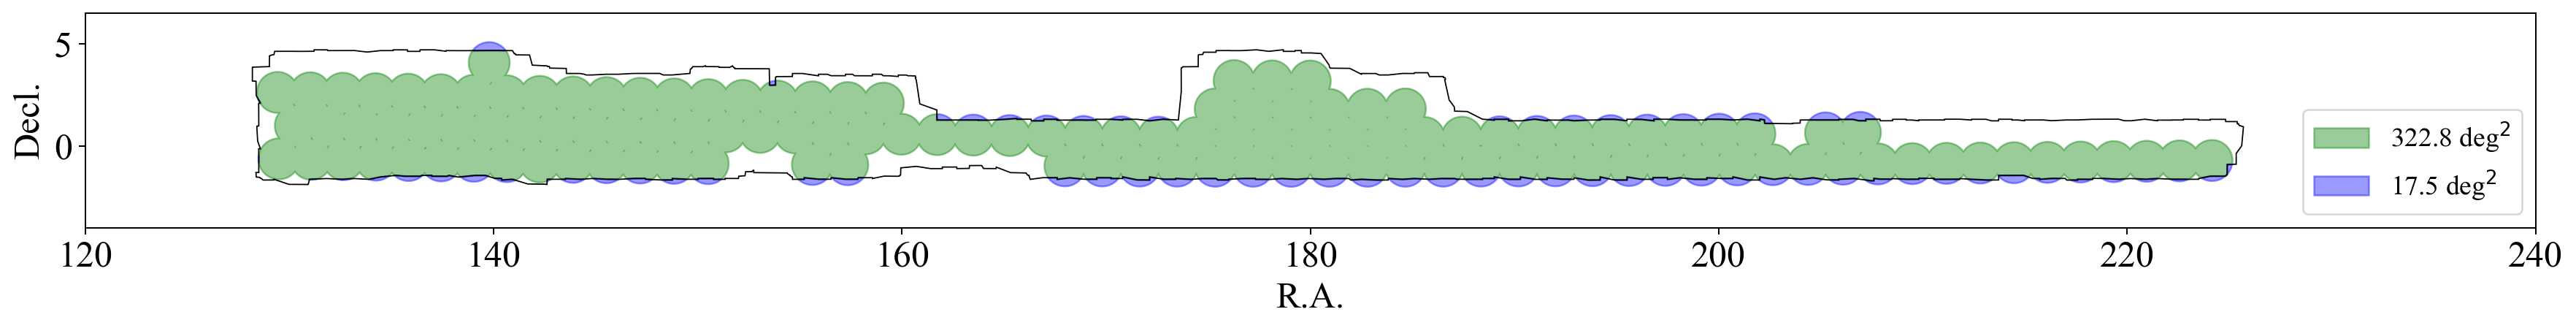

In [41]:
fig = plt.figure(1, figsize=(20, 10), dpi=180)
ax = fig.add_subplot(111, aspect='equal')
patch_inter = PolygonPatch(inter, alpha=0.4, color='g', label= r'' +str(round(inter.area,1))+' deg$^2$')
ax.add_patch(patch_inter)
patch_diff = PolygonPatch(diff, alpha=0.4, color='b', label= r'' +str(round(diff.area,1))+' deg$^2$')
ax.add_patch(patch_diff)
patch = PolygonPatch(poly_gama_S20A, edgecolor='k',facecolor='none',lw=0.7)
ax.add_patch(patch)
ax.set_xlim(120,240)
ax.set_ylim(-4,6.5)
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')

plt.rcParams["font.family"] = "Times New Roman"
plt.legend(loc='lower right', fontsize=15)
plt.tight_layout()
# plt.savefig('../figures/areas_90.jpeg', bbox_inches='tight', dpi=700)


In [24]:
gama_union.area
# plt.plot(gama_union)

271.17211843703376

In [76]:
frac_from_survey = round((100*poly_gama_S20A.area/800.),1)
total_nights = 30
print('Total area of the GAMA field: ' + str(round(poly_gama_S20A.area,1)))
print('Which is '+ str(frac_from_survey)+ '% of the total Merian Survey area')
print('So given that we have 30 nights for the wide survey in one filter, we want to spend on this field '+str(total_nights*frac_from_survey/100)+' nights')
print('With this plan, the number of pointings for the GAMA09 field: ' + str(count*4))

print('Each pointing is 10 minutes, so we will spend a total of: ' + str(round(count*4*10/60,1))+' hours on this field')
print('Assuming 8 hours a night, that means: ' + str(round(count*4*10/60/8,6)) + ' nights')


Total area of the GAMA field: 402.0
Which is 50.3% of the total Merian Survey area
So given that we have 30 nights for the wide survey in one filter, we want to spend on this field 15.09 nights
With this plan, the number of pointings for the GAMA09 field: 512
Each pointing is 10 minutes, so we will spend a total of: 85.3 hours on this field
Assuming 8 hours a night, that means: 10.666667 nights


## get all four passes that overlap with the GAMA09 field

In [78]:
# fig = plt.figure(1, figsize=(15,4), dpi=180)
# ax = fig.add_subplot(111, aspect='equal')
count_again = 0
ra_gama_final = []
dec_gama_final = []
for i in range(len(index_use)):
    count_again += 4
    j = index_use[i]
    ax.scatter(ra1_shift[j],dec1_shift[j],color='#a65628')
    ax.scatter(ra2_shift[j],dec2_shift[j],color='#e41a1c')
    ax.scatter(ra3_shift[j],dec3_shift[j],color='#377eb8')
    ax.scatter(ra4_shift[j],dec4_shift[j],color='#984ea3')
    
    # append coordiantes to the final catalog
    ra_gama_final.append(ra1_shift[j])
    ra_gama_final.append(ra2_shift[j])
    ra_gama_final.append(ra3_shift[j])
    ra_gama_final.append(ra4_shift[j])
    dec_gama_final.append(dec1_shift[j])
    dec_gama_final.append(dec2_shift[j])
    dec_gama_final.append(dec3_shift[j])
    dec_gama_final.append(dec4_shift[j])
    
# patch = PolygonPatch(poly_gama_S20A, edgecolor='k',facecolor='none',lw=5)
# ax.add_patch(patch)

print('# of pointings: ' + str(count_again))

# of pointings: 512


In [44]:
# print('total # of pointings for the GAMA field: '+str(point_counter)) 

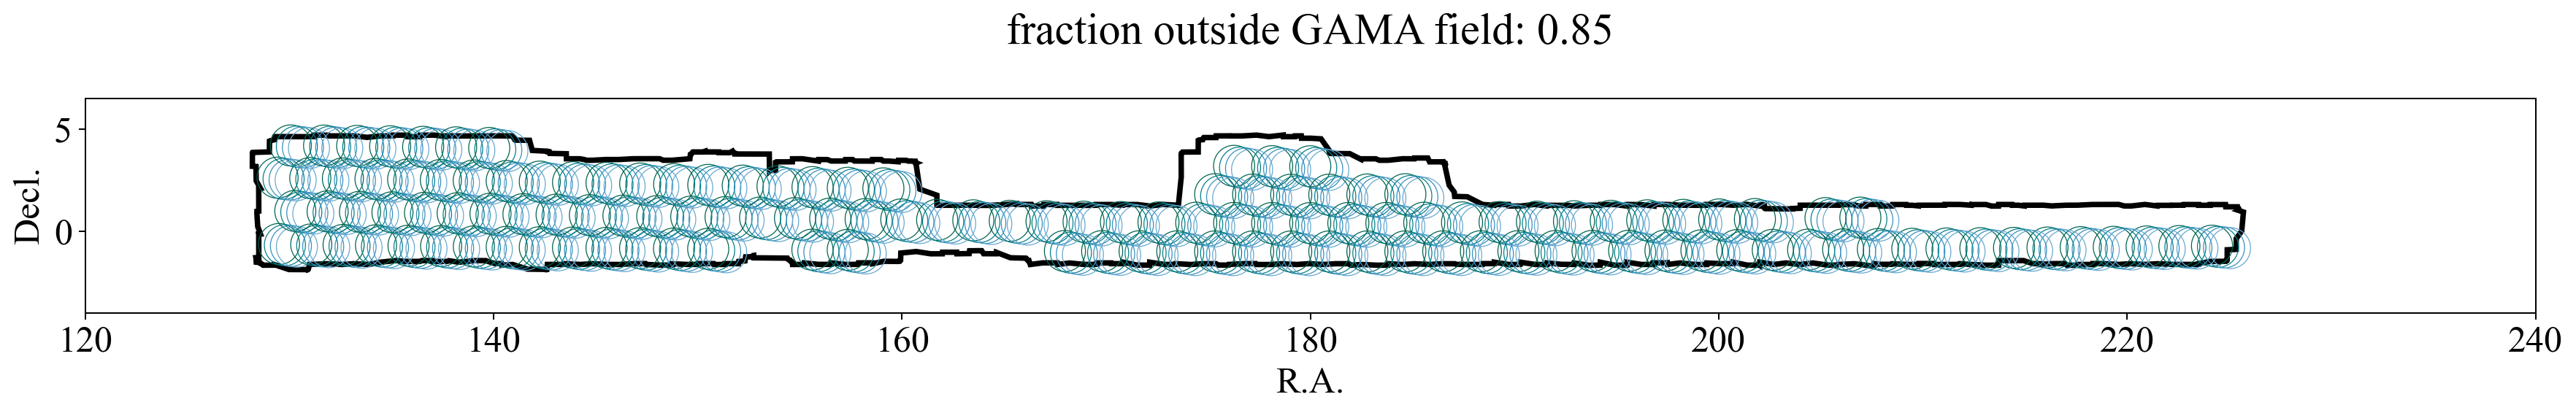

In [79]:
fig = plt.figure(1, figsize=(20,10), dpi=180)
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] = 20
plt.rcParams['axes.titlepad'] = 30

ax = fig.add_subplot(111, aspect='equal')
patch = PolygonPatch(poly_gama_S20A, edgecolor='k',facecolor='none',lw=3)
ax.add_patch(patch)

point_counter = 0

for i in range(len(index_use)):
    patch1 = PolygonPatch(circles_pass1_shift[index_use[i]],lw=0.5,facecolor='none',edgecolor='#016450')
    patch2 = PolygonPatch(circles_pass2_shift[index_use[i]],lw=0.5,facecolor='none',edgecolor='#02818a')
    patch3 = PolygonPatch(circles_pass3_shift[index_use[i]],lw=0.5,facecolor='none',edgecolor='#3690c0')
    patch4 = PolygonPatch(circles_pass4_shift[index_use[i]],lw=0.5,facecolor='none',edgecolor='#67a9cf')

    point_counter +=4
    
    ax.add_patch(patch1)
    ax.add_patch(patch2)
    ax.add_patch(patch3)
    ax.add_patch(patch4)
        
ax.set_xlim(120,240)
ax.set_ylim(-4,6.5)
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')

plt.title('fraction outside GAMA field: '+str(fraction))
plt.tight_layout()
# plt.savefig('../figures/gama_all_pointings_shift_85.jpeg', bbox_inches='tight',dpi=700)


## initialize ObservingCatalog; build JSON file

In [81]:
# ocat = observe.ObsCatalog(comment='--', proposer='LeathaudGreene')
ocat = observe.ObsCatalog(comment='--', proposer='LeathaudGreene', propid='2020B-0288', seqid='S2021A')

df = ocat.build_catalog(ra_gama_final, dec_gama_final, 'GAMA', 'N70', 'object', 10.*60)

In [82]:
# df.to_csv('../json/gama_90.csv')
df.to_csv('../json/gama.csv')

In [83]:
df

,comment,filter,seqtot,seqnum,seqid,expType,object,proposer,program,RA,propid,dec,expTime,count
0,--,N70,512,1,S2021A,object,GAMA,LeathaudGreene,Merian,200.907909,2020B-0288,-0.934167,600.0,1
1,--,N70,512,2,S2021A,object,GAMA,LeathaudGreene,Merian,201.200153,2020B-0288,-1.010001,600.0,1
2,--,N70,512,3,S2021A,object,GAMA,LeathaudGreene,Merian,201.494921,2020B-0288,-1.054498,600.0,1
3,--,N70,512,4,S2021A,object,GAMA,LeathaudGreene,Merian,201.789712,2020B-0288,-1.098778,600.0,1
4,--,N70,512,5,S2021A,object,GAMA,LeathaudGreene,Merian,224.159362,2020B-0288,-0.717440,600.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,--,N70,512,508,S2021A,object,GAMA,LeathaudGreene,Merian,159.106597,2020B-0288,0.410528,600.0,1
508,--,N70,512,509,S2021A,object,GAMA,LeathaudGreene,Merian,157.349899,2020B-0288,-0.922888,600.0,1
509,--,N70,512,510,S2021A,object,GAMA,LeathaudGreene,Merian,157.641097,2020B-0288,-1.001874,600.0,1
510,--,N70,512,511,S2021A,object,GAMA,LeathaudGreene,Merian,157.935198,2020B-0288,-1.050316,600.0,1


In [18]:
ocat.to_json(df,fp='../json/g09.json')

In [19]:
# Load all the targets as SkyCoordinates
cosmos = coordinates.SkyCoord ("10h00m28.6s+02d12m21.0s")
gama09 = coordinates.SkyCoord ( df.RA.values, df.dec.values, unit=u.deg)

In [20]:
ctio = observe.ObservingSite ()

In [21]:
center = datetime.datetime ( 2021, 3, 12, 3, tzinfo=pytz.utc )
obsframe = ctio.define_obsframe ( center )
alt_cosmos = ctio.get_altitude ( cosmos, obsframe )

NameError: name 'datetime' is not defined

In [ ]:
alt_l = [ ctio.get_altitude(c_coord, obsframe) for c_coord in gama09 ] 

In [ ]:
ax = visualize.plot_altitude ( alt_l[0], ctio )
for idx in np.arange(1,len(alt_l),20):
    visualize.plot_altitude ( alt_l[idx], ctio, ax=ax )
visualize.plot_altitude ( alt_cosmos, ctio, ax=ax, color='k', ls='--',)